<a href="https://colab.research.google.com/github/aagamj/Stocks/blob/main/ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install mplfinance
!pip install yfinance

     |████████████████████████████████| 6.3 MB 6.8 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=e7567d818c86608e529ba205f8a3aa5f861a89b8c1e4de8b1982ea5f1d0d0c8f
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


- AAPL: Invalid input - interval=1w is not supported. Valid intervals: , 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo]
Optimum K is 0


IndexError: ignored

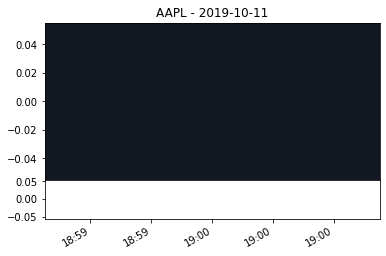

In [15]:
import datetime
import pytz
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import matplotlib.ticker as mpticker
import pandas
import numpy
from mplfinance.original_flavor import candlestick_ohlc

import yfinance as yf
yf.pdr_override()


def get_optimum_clusters(df, saturation_point=0.05):
    '''
    :param df: dataframe
    :param saturation_point: The amount of difference we are willing to detect
    :return: clusters with optimum K centers
    This method uses elbow method to find the optimum number of K clusters
    We initialize different K-means with 1..10 centers and compare the inertias
    If the difference is no more than saturation_point, we choose that as K and move on
    '''

    wcss = []
    k_models = []

    size = min(11, len(df.index))
    for i in range(1, size):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(df)
        wcss.append(kmeans.inertia_)
        k_models.append(kmeans)

    # Compare differences in inertias until it's no more than saturation_point
    optimum_k = len(wcss)-1
    for i in range(0, len(wcss)-1):
        diff = abs(wcss[i+1] - wcss[i])
        if diff < saturation_point:
            optimum_k = i
            break

    print("Optimum K is " + str(optimum_k + 1))
    optimum_clusters = k_models[optimum_k]

    return optimum_clusters


def plot_stock_data(data):
    fig, ax = plt.subplots()
    ax1 = plt.subplot2grid((5,1), (0,0), rowspan=4)
    ax2 = plt.subplot2grid((5,1), (4,0), sharex=ax1)

    ax1.set_title("{} - {}".format(symbol, start))
    ax1.set_facecolor("#131722")
    ax1.xaxis.set_major_formatter(mpticker.FuncFormatter(mydate))

    candlestick_ohlc(ax1, data.to_numpy(), width=8, colorup='#77d879', colordown='#db3f3f')

    ax2.bar(data['Time'], data['Volume'], width=30)
    ax2.xaxis.set_major_formatter(mpticker.FuncFormatter(mydate))
    fig.subplots_adjust(hspace=0)
    fig.autofmt_xdate()
    return ax1


def mydate(x,pos):
    try:
        return datetime.datetime.fromtimestamp(x, tz=est).strftime(date_format)
    except IndexError:
        return ''


symbol = "AAPL"
start = "2021-10-11"
end = "2021-10-12"
est = pytz.timezone('US/Eastern')
date_format = "%H:%M"

ticker = yf.Ticker(symbol)
data = ticker.history(period="1y", interval="1w",start=start, end=end, prepost=False, actions=False)
data = data[:60] #30 1M candles

data["Time"] = [d.timestamp() for d in data.index]
data.Time = data.Time.tz_convert(est)
data = data[["Time", "Open", "High", "Low", "Close", "Volume"]]

ax = plot_stock_data(data)

lod, hod = 0, 0

lows = pandas.DataFrame(data=data, index=data.index, columns=["Low"])
highs = pandas.DataFrame(data=data, index=data.index, columns=["High"])

low_clusters = get_optimum_clusters(lows)
low_centers = low_clusters.cluster_centers_
low_centers = numpy.sort(low_centers, axis=0)

high_clusters = get_optimum_clusters(highs)
high_centers = high_clusters.cluster_centers_
high_centers = numpy.sort(high_centers, axis=0)

print(data)
print(low_centers)
print(high_centers)

for low in low_centers[:2]:
    ax.axhline(low[0], color='yellow', ls='--')

for high in high_centers[-1:]:
    ax.axhline(high[0], color='orange', ls='--')

plt.show()